In [6]:
from utils import (
    read_patient_data,
    preprocess_data,
    plot_catagorical_feature_distribution,
    plot_catagorical_feature_distribution_for_each_pathology
)

### Analysis

In [2]:
directory = '../ddxplus/raw-data'
initial_evidence = 'toux'
df = read_patient_data(directory, split='test')
df = df[df['INITIAL_EVIDENCE'] == initial_evidence] 
df = preprocess_data(directory, df)
df.head()

,AGE,DIFFERENTIAL_DIAGNOSIS,SEX,PATHOLOGY,EVIDENCES,INITIAL_EVIDENCE,DIFFERENTIAL_DIAGNOSIS_WITHOUT_PROB,PATHOLOGY_ENG,DIFFERENTIAL_DIAGNOSIS_WITHOUT_PROB_ENG
0,49,"[[Bronchite, 0.20230062181160519], [RGO, 0.179...",F,RGO,"[douleurxx, douleurxx_carac_@_lancinante_/_cho...",toux,"[Bronchite, RGO, Possible NSTEMI / STEMI, Angi...",GERD,"[Bronchitis, GERD, Possible NSTEMI / STEMI, Un..."
4,70,"[[IVRS ou virémie, 0.21257615919851483], [Poss...",F,IVRS ou virémie,"[contact, diaph, douleurxx, douleurxx_carac_@_...",toux,"[IVRS ou virémie, Possible influenza ou syndro...",URTI,"[URTI, Influenza, Bronchitis, HIV (initial inf..."
22,10,[[Possible influenza ou syndrome virémique typ...,F,Possible influenza ou syndrome virémique typique,"[diaph, douleurxx, douleurxx_carac_@_une_lourd...",toux,[Possible influenza ou syndrome virémique typi...,Influenza,"[Influenza, URTI, HIV (initial infection), Bro..."
26,1,"[[Bronchite, 0.29070421508775757], [Otite moye...",M,Otite moyenne aigue (OMA),"[H6690, douleurxx, douleurxx_carac_@_sensible,...",toux,"[Bronchite, Otite moyenne aigue (OMA), Pneumon...",Acute otitis media,"[Bronchitis, Acute otitis media, Pneumonia, Tu..."
52,77,"[[IVRS ou virémie, 0.24961180257533938], [Bron...",M,IVRS ou virémie,"[crowd, douleurxx, douleurxx_carac_@_pénible, ...",toux,"[IVRS ou virémie, Bronchite, Possible influenz...",URTI,"[URTI, Bronchitis, Influenza, Tuberculosis, HI..."


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9618 entries, 0 to 134483
Data columns (total 9 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   AGE                                      9618 non-null   int64 
 1   DIFFERENTIAL_DIAGNOSIS                   9618 non-null   object
 2   SEX                                      9618 non-null   object
 3   PATHOLOGY                                9618 non-null   object
 4   EVIDENCES                                9618 non-null   object
 5   INITIAL_EVIDENCE                         9618 non-null   object
 6   DIFFERENTIAL_DIAGNOSIS_WITHOUT_PROB      9618 non-null   object
 7   PATHOLOGY_ENG                            9618 non-null   object
 8   DIFFERENTIAL_DIAGNOSIS_WITHOUT_PROB_ENG  9618 non-null   object
dtypes: int64(1), object(8)
memory usage: 751.4+ KB


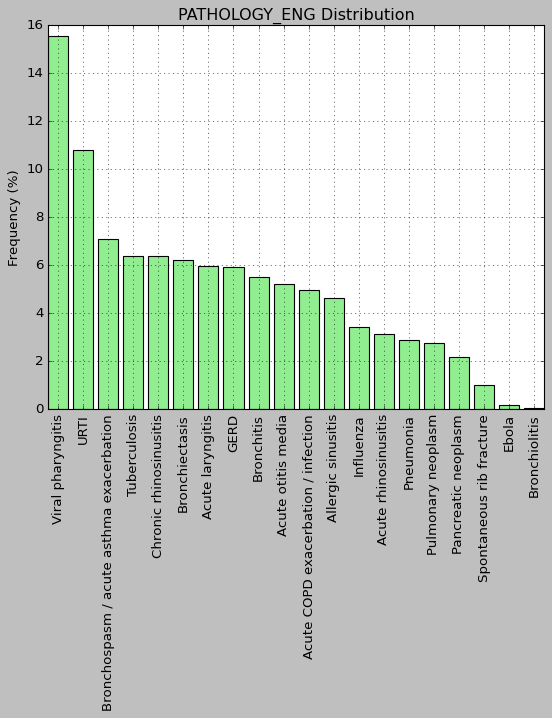

In [5]:
plot_catagorical_feature_distribution(df, feature='PATHOLOGY_ENG')

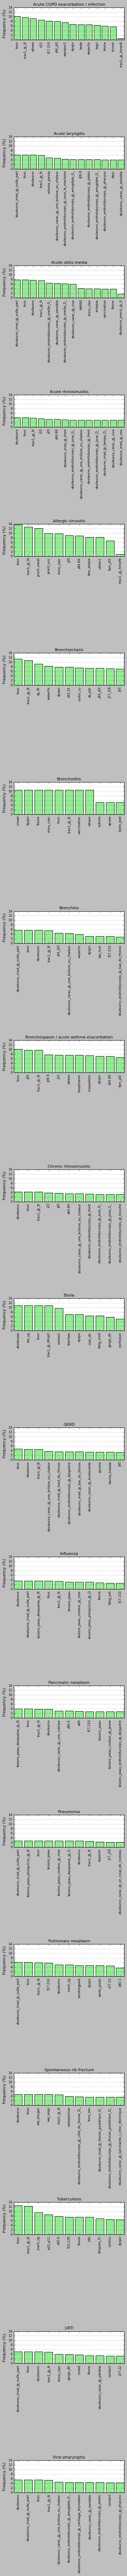

In [7]:
plot_catagorical_feature_distribution_for_each_pathology(df, feature='EVIDENCES')

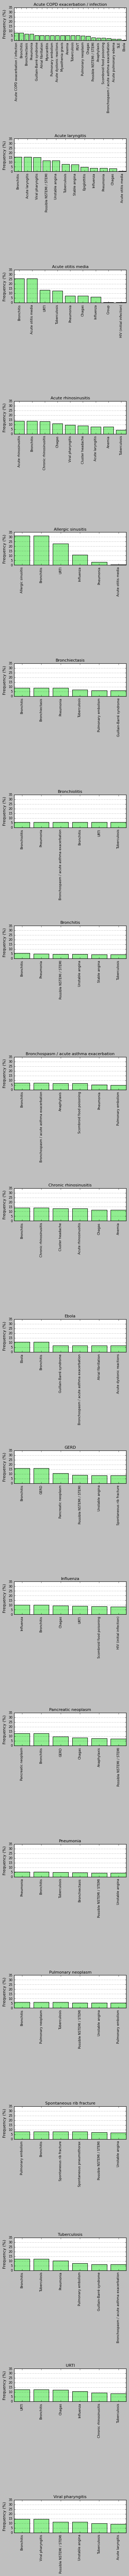

In [8]:
plot_catagorical_feature_distribution_for_each_pathology(df, feature='DIFFERENTIAL_DIAGNOSIS_WITHOUT_PROB_ENG')

In [9]:
# Generate eda report
# 
# There are threee main section:
#   1. Overview: Basic statistial information of the dataset
#   2. Variables: Detailed statistial information of each variable (i.e., column)
#   3. Interactions: In this section you can plot one variable against another for observing relatedness.
#   4. Coorelations: Observe correlatioon between variables.
#   5. Missing values: Observe missing values in the dataset.
#   6. Sample: Observe the first 10 and last 10 rows of the dataset.
#
# [ref] https://towardsdatascience.com/pandas-profiling-easy-exploratory-data-analysis-in-python-65d6d0e23650

# from pandas_profiling import ProfileReport
# report = ProfileReport(patient_testing_set_toux)
# report